In [0]:
%tensorflow_version 2.x

In [5]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.1.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd

In [0]:
# Read the data file
#df = pd.read_csv("./SAS1.csv")
df = pd.read_csv("./daily_drinks_consumption.csv")
df.head(5)

,date,Latte,Iced Latte,Americano,Coffee,Iced Chai,Mocha,Chai Latte,Hot Chocolate,Iced Coffee,Cappuccino,Espresso,Cafe Au Lait,Steamed Milk,Black Tea,Iced Black Tea,Almond Milk Latte,Iced Caramel Latte Macchiato,Iced Caramel Latte,Pumpkin Spice Latte,Iced Vanilla Latte,Vanilla Latte,Iced Pumpkin Spice Latte,Caramel Latte Macchiato,Iced Dirty Chai,Vanilla Steamer,Dirty Chai,Skinny Hot Chocolate,Iced Almond Milk Latte,Mocha Macchiauto,Caramel Latte
0,6/18/2018,1,1,0,1,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6/19/2018,20,17,12,16,8,3,2,1,10,7,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6/20/2018,9,16,13,17,5,9,3,1,9,7,1,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6/21/2018,19,15,6,30,4,8,4,0,5,5,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6/22/2018,14,13,9,15,3,5,3,2,12,5,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Generate a Series
#drinks_amount = df['amount']
#drinks_amount.index = df['date']
drinks_amount = df['Latte']
drinks_amount.index = df['date']
drinks_amount.head()

date
6/18/2018     1
6/19/2018    20
6/20/2018     9
6/21/2018    19
6/22/2018    14
Name: Latte, dtype: int64

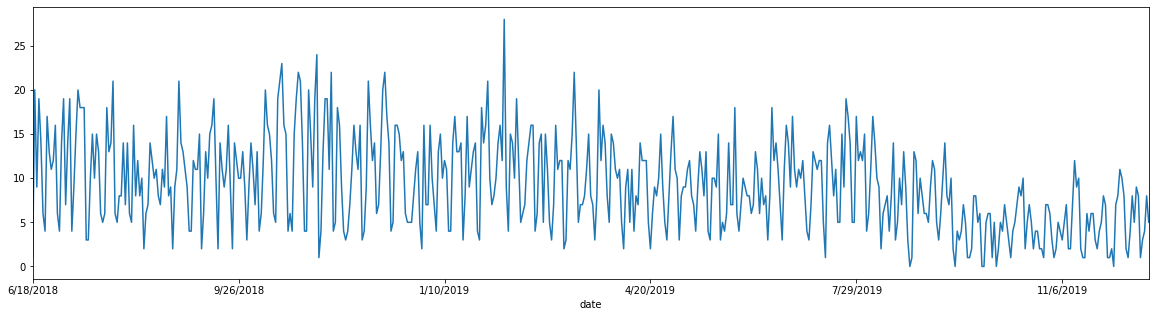

In [0]:
# Plot the daily drink amount 
drinks_amount.plot(figsize=(20, 5))

In [0]:
drinks_data = drinks_amount.values

In [0]:
# Get the mean and std of the traning dataset
TRAIN_SPLIT = 450
train_mean = drinks_data[:TRAIN_SPLIT].mean()
train_std = drinks_data[:TRAIN_SPLIT].std()
print(train_mean, train_std)

10.244444444444444 5.0620836972559715


In [0]:
drinks_data = (drinks_data - train_mean) / train_std
drinks_data.shape

(543,)

In [0]:
def assembel_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i)    
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    if single_step:
        labels.append(dataset[i + target_size])
    else:
        labels.append(dataset[i: i + target_size])
  return np.array(data), np.array(labels)

In [0]:
# Assembel the data based on the history size and predicting size
history_size = 14
future_target = 7

x_train, y_train = assembel_data(drinks_data, 0, TRAIN_SPLIT, history_size, future_target)
x_val, y_val = assembel_data(drinks_data, TRAIN_SPLIT, None, history_size, future_target)


In [0]:
print("the size of the training set is: {}".format(x_train.shape[0])) # original 400
print("the size of the validation set is: {}".format(x_val.shape[0])) # origin 143
#print ('history data sample:\n{}'.format(x_val[1]))
#print ('target label sample:\n{}'.format(y_val[1]))

the size of the training set is: 436
the size of the validation set is: 72


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
BATCH_SIZE = 20
BUFFER_SIZE = 500

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
#multi step lstm model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
#multi_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:])))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
#multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))


multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(7))

#optimizer = tf.keras.optimizers.RMSprop(clipvalue=1.0)
optimizer = tf.keras.optimizers.SGD(lr=5e-3, momentum=0.9)
#multi_step_model.compile(optimizer=optimizer, loss='mae', metrics = ['accuracy'])
multi_step_model.compile(optimizer=optimizer, loss='mae')
multi_step_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 32)            4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 21,447
Trainable params: 21,447
Non-trainable params: 0
_________________________________________________________________


In [0]:
#test, to guarantee the output shape is correct
for x, y in val_univariate.take(3):
  print (multi_step_model.predict(x).shape)

(20, 7)
(20, 7)
(20, 7)


In [0]:
'''
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
multi_step_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = multi_step_model.fit(train_univariate, epochs=100, steps_per_epoch=200, callbacks=[lr_schedule])
'''

'\nlr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))\noptimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)\nmulti_step_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])\nhistory = multi_step_model.fit(train_univariate, epochs=100, steps_per_epoch=200, callbacks=[lr_schedule])\n'

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.4):
            print("reached 70% accuracy so cancelling training!")
            self.model.stop_training = True

In [0]:
callbacks = myCallback()

# Train the model
#EVALUATION_INTERVAL = 200
EVALUATION_INTERVAL = math.ceil(len(drinks_data) / BATCH_SIZE)
print("EVALUATION_INTERVAL is:{}".format(EVALUATION_INTERVAL))
EPOCHS = 500

multi_step_history = multi_step_model.fit(train_univariate, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_univariate,
                                          validation_steps=50, callbacks=[callbacks])

EVALUATION_INTERVAL is:28
Train for 28 steps, validate for 50 steps
Epoch 1/500
28/28 [==============================] - 4s 130ms/step - loss: 0.8264 - val_loss: 1.0491
Epoch 2/500
28/28 [==============================] - 0s 14ms/step - loss: 0.8139 - val_loss: 1.0169
Epoch 3/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8298 - val_loss: 1.0172
Epoch 4/500
28/28 [==============================] - 0s 14ms/step - loss: 0.8113 - val_loss: 1.0036
Epoch 5/500
28/28 [==============================] - 0s 14ms/step - loss: 0.8295 - val_loss: 0.9930
Epoch 6/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8114 - val_loss: 0.9824
Epoch 7/500
28/28 [==============================] - 0s 14ms/step - loss: 0.8119 - val_loss: 0.9726
Epoch 8/500
28/28 [==============================] - 0s 14ms/step - loss: 0.8174 - val_loss: 0.9672
Epoch 9/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8055 - val_loss: 0.9526
Epoch 10/500
28/28 [===========

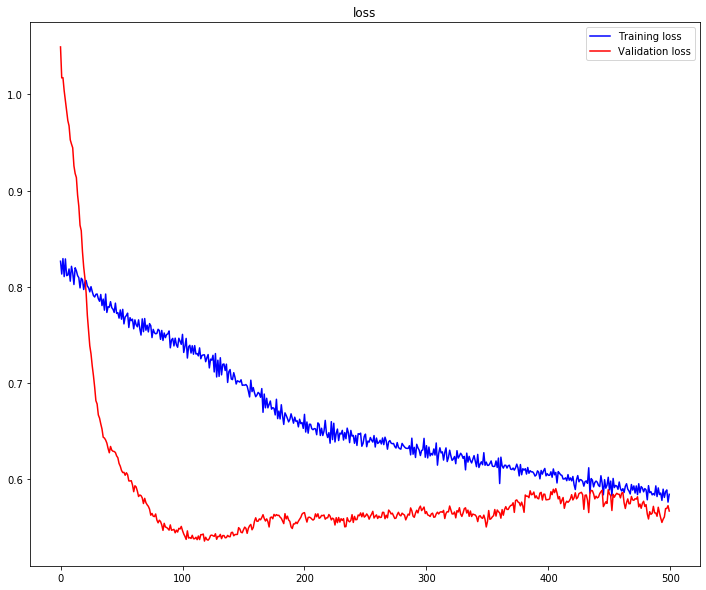

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  #acc = history.history['accuracy']
  #val_acc = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.figure(figsize=(12,10))
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()
  #plt.savefig('temp.png', dpi=fig.dpi)

plot_train_history(multi_step_history, "loss")

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(20, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), 'go--', linewidth=2, markersize=5, label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo--', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r*--', label='Predicted Future')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.show()

In [0]:
def multi_step_plot1(history, true_future, prediction):
  plt.figure(figsize=(20, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), 'g-', linewidth=2, markersize=5, label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'g-', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r*--', label='Predicted Future')
  #
  plt.grid(True)
  plt.show()

In [0]:
drinks_data[:-14].shape

(529,)

In [0]:
for x, y in val_univariate.take(1):
    print(len(y))


20


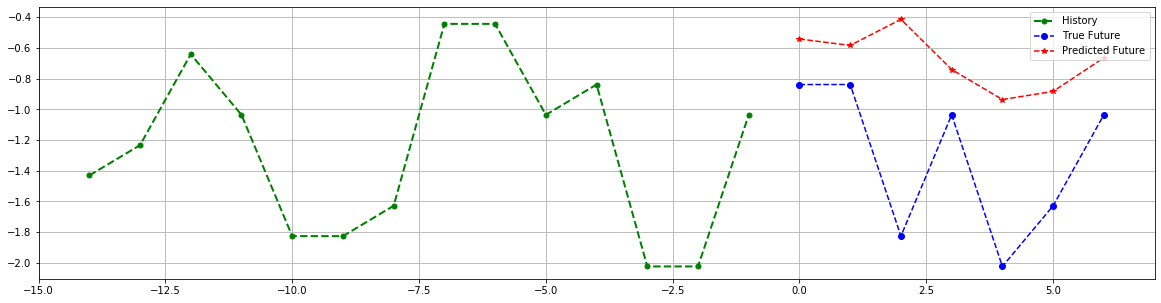

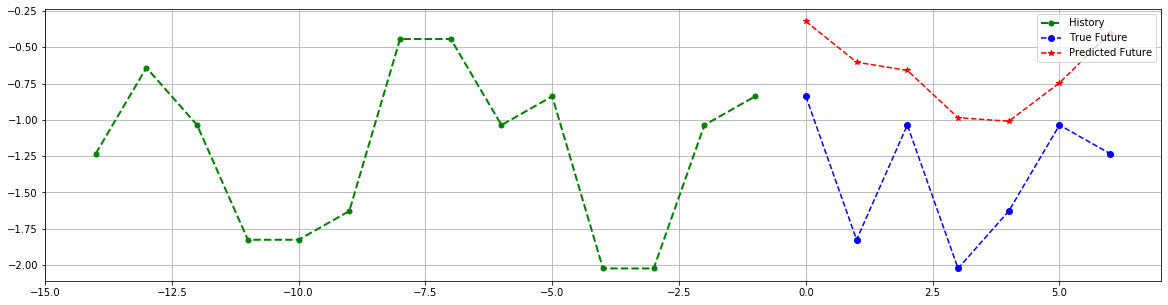

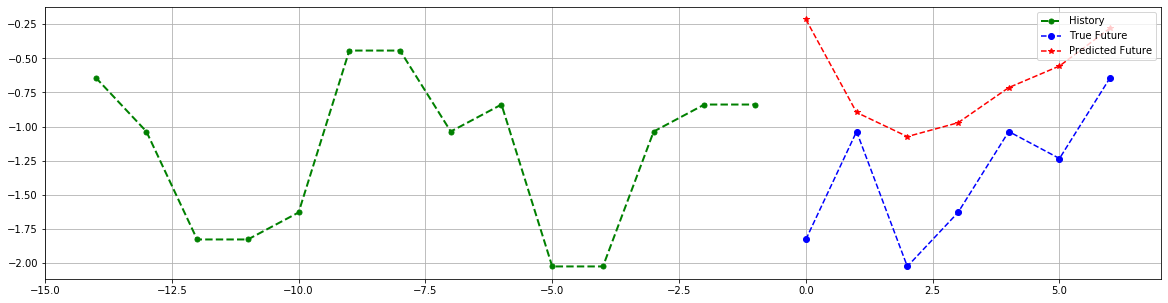

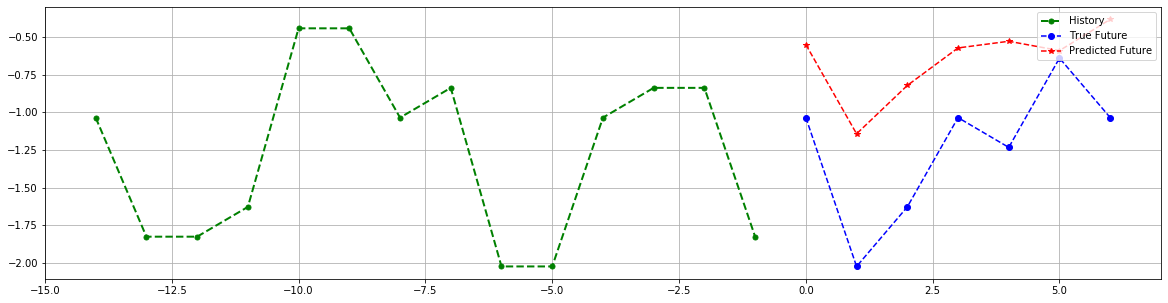

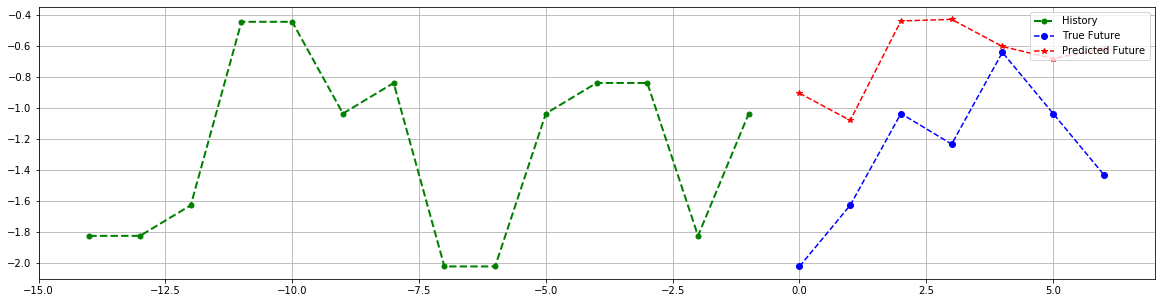

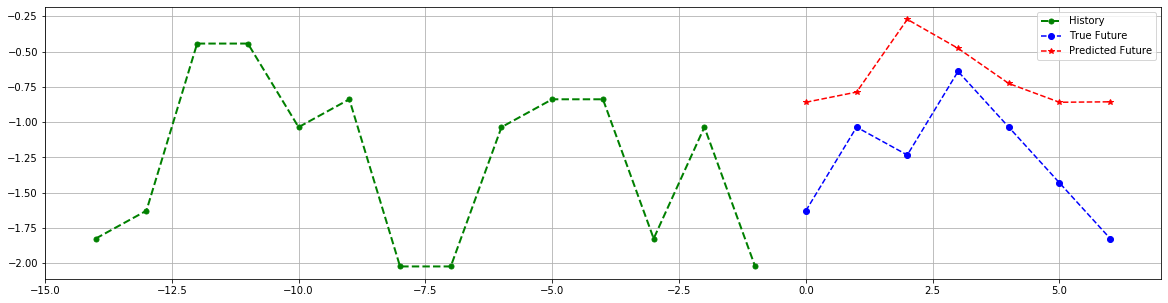

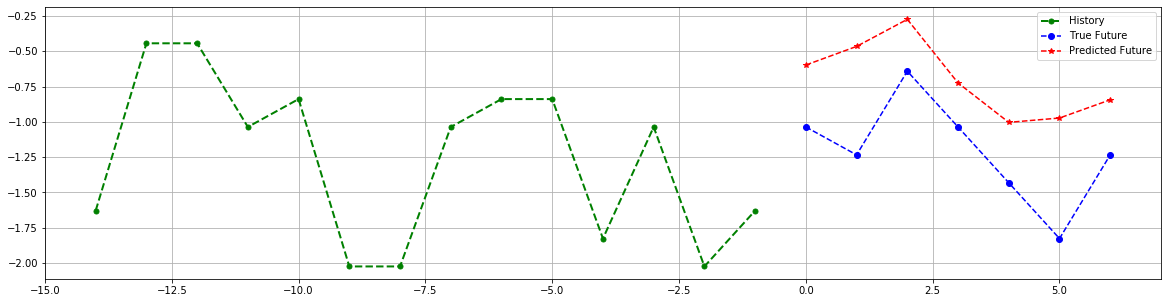

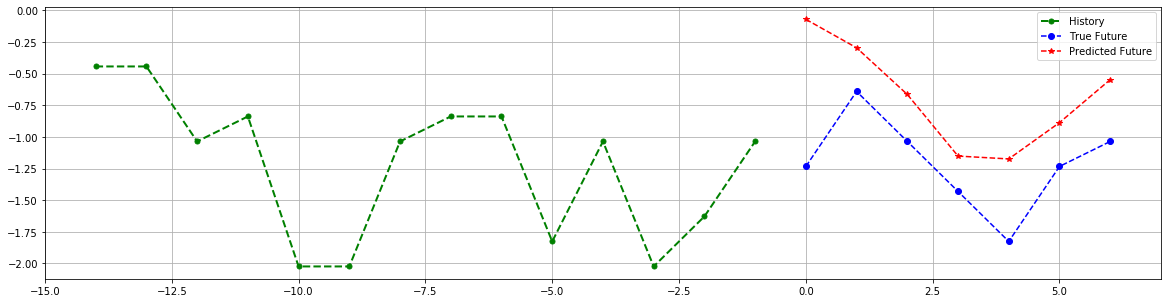

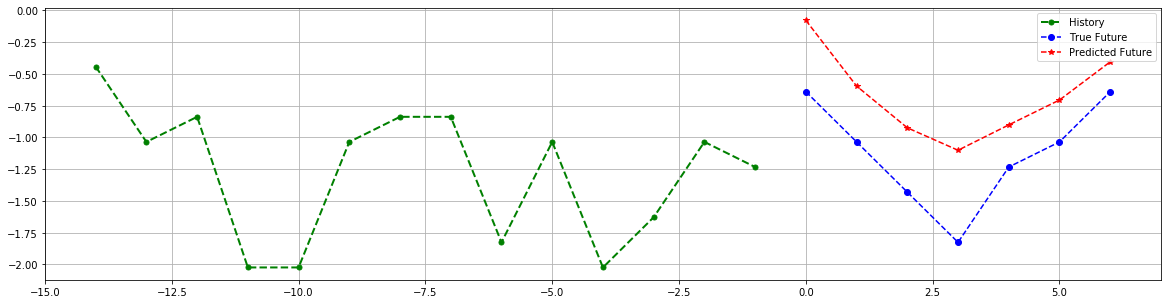

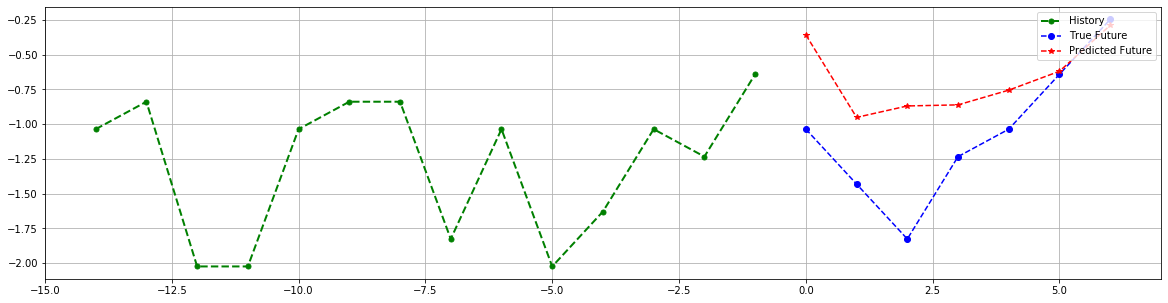

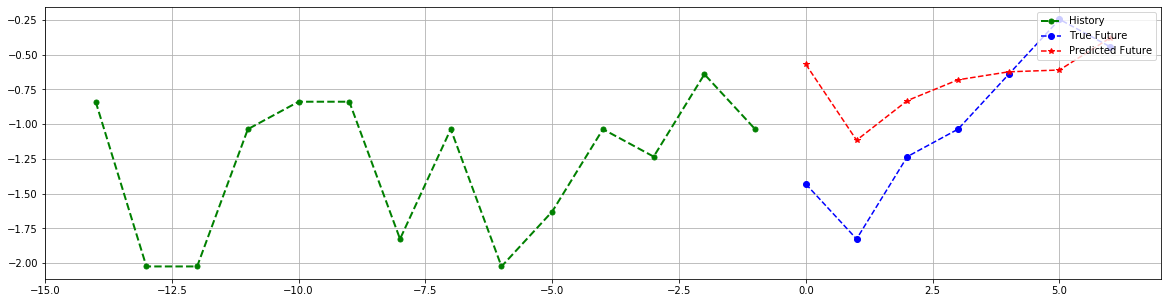

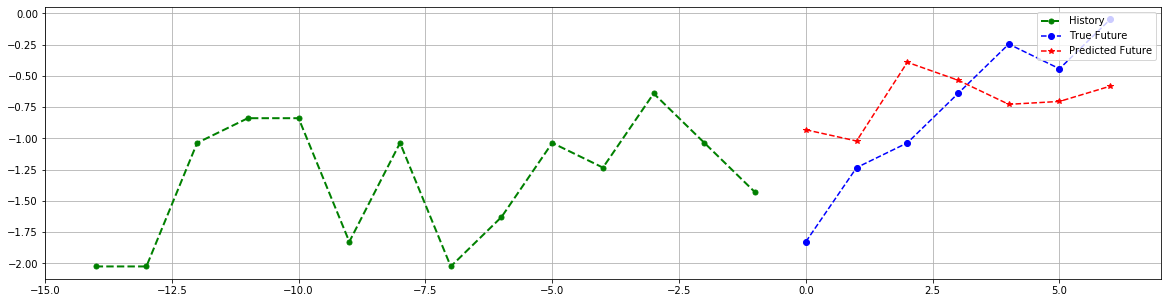

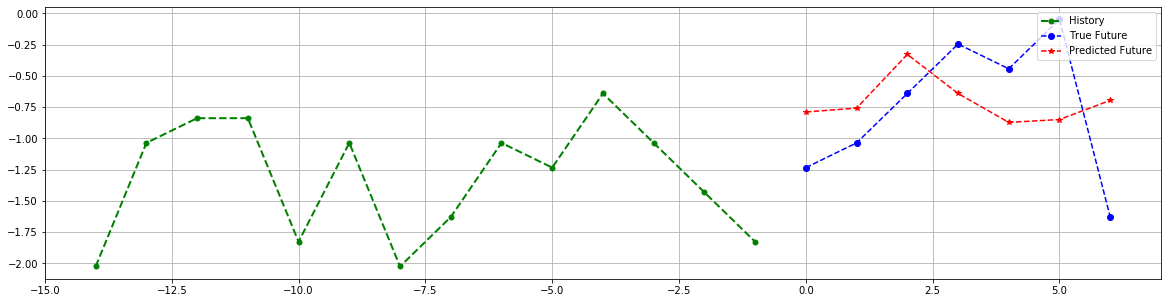

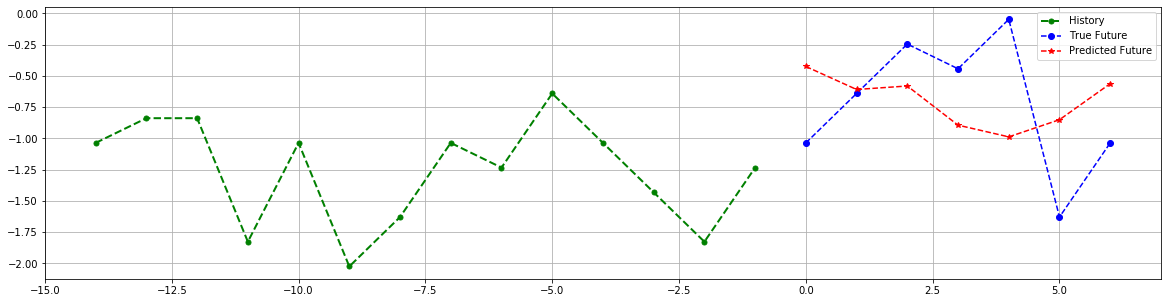

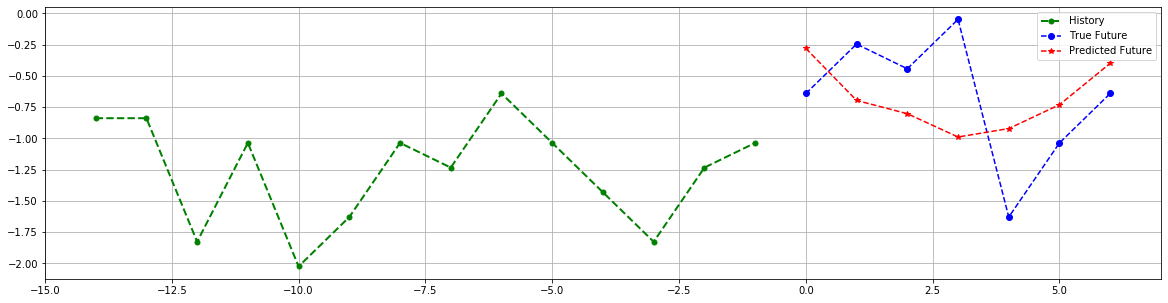

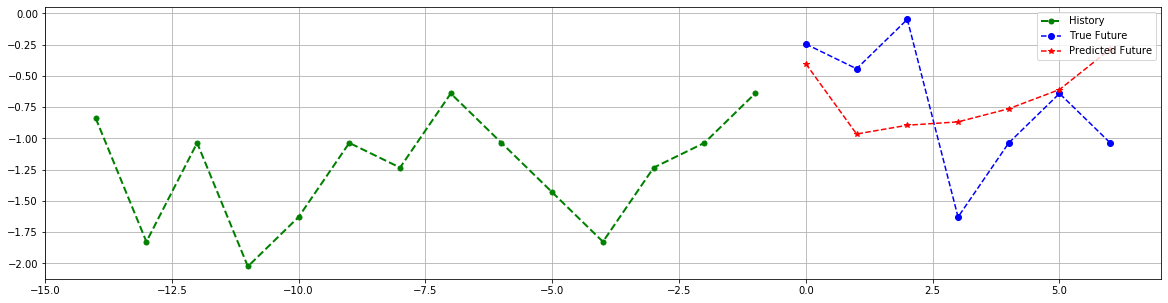

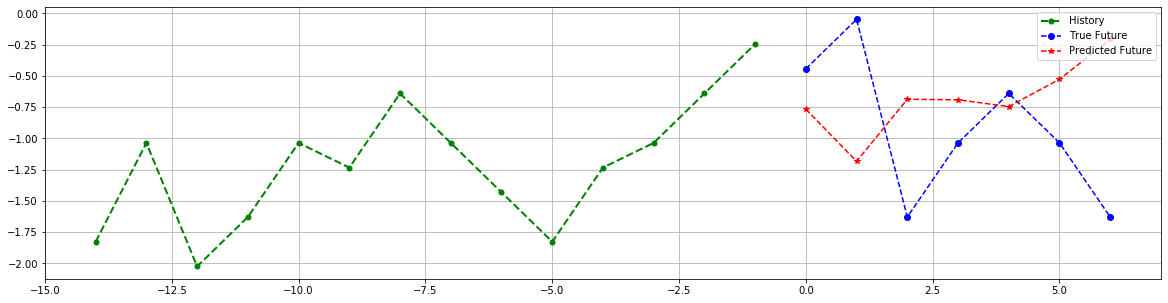

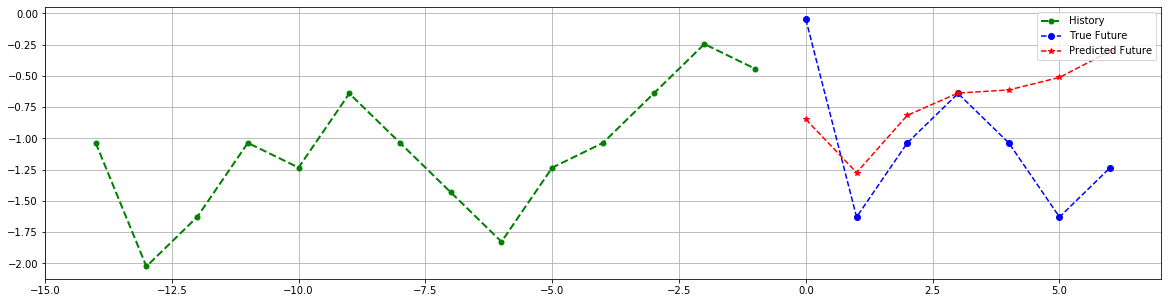

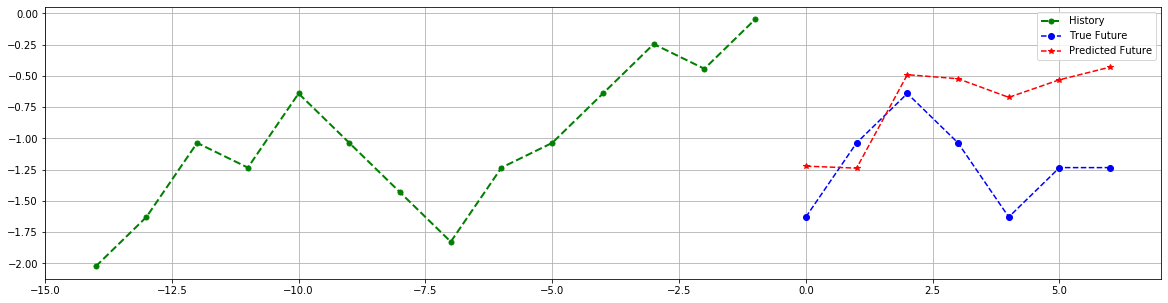

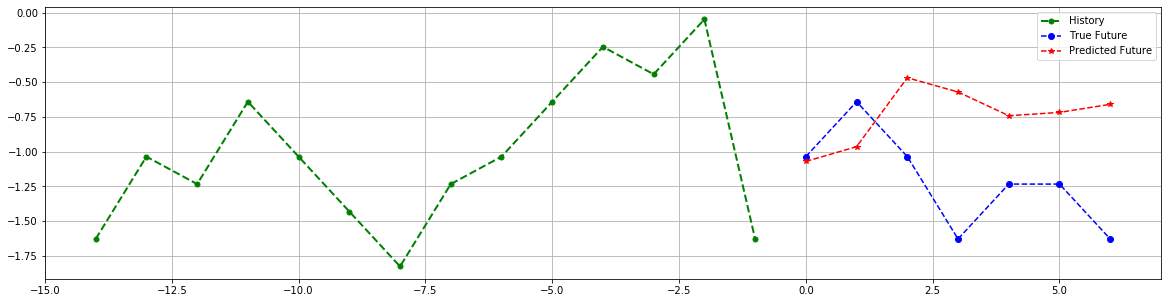

In [0]:
# Plot the true value and predicted value
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        multi_step_plot(x[i], y[i], multi_step_model.predict(x)[i])


In [0]:
# Evaluation
# The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms.
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


In [0]:
def evaluation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    '''
    print('R^2   test: %.2f' % r2_score(y_true, y_pred))
    print('MSE   test: %.2f' % mean_squared_error(y_true, y_pred))
    print('RMSE  test: %.2f' % np.sqrt(mean_squared_error(y_true, y_pred)))
    print('MAE   test: %.2f' % mean_absolute_error(y_true, y_pred))
    '''


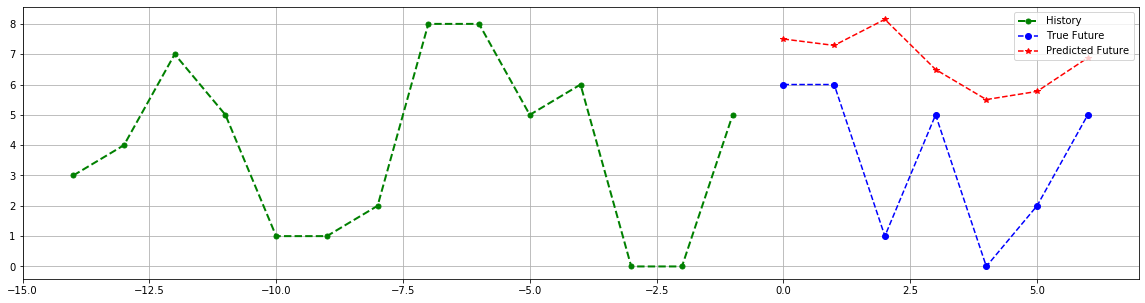

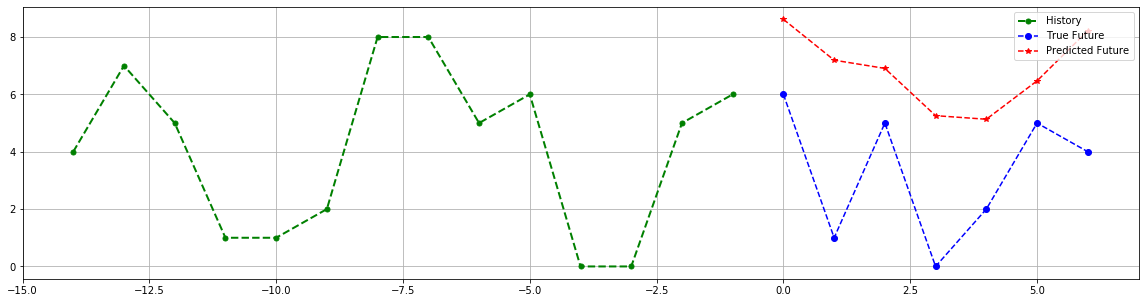

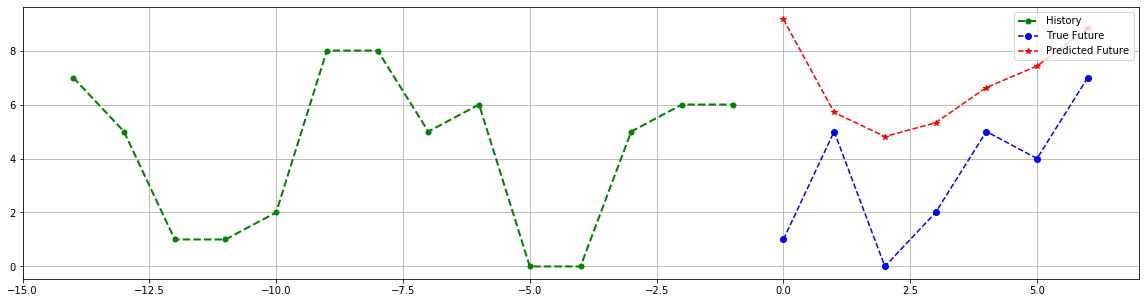

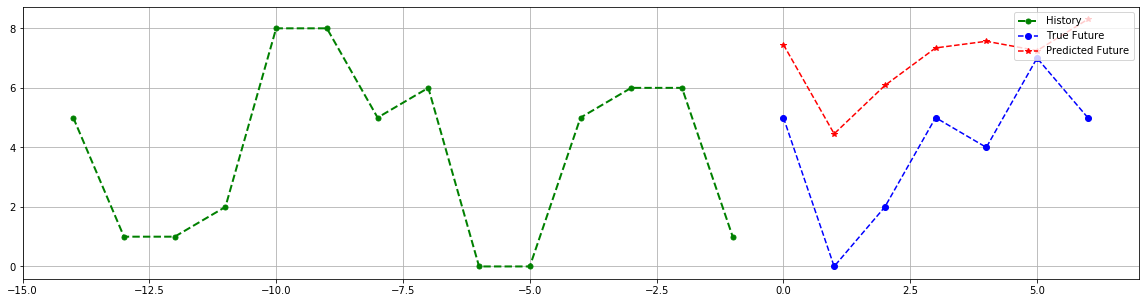

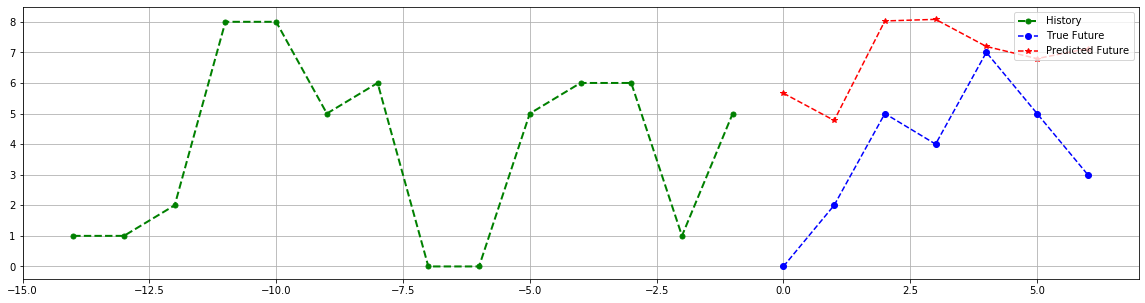

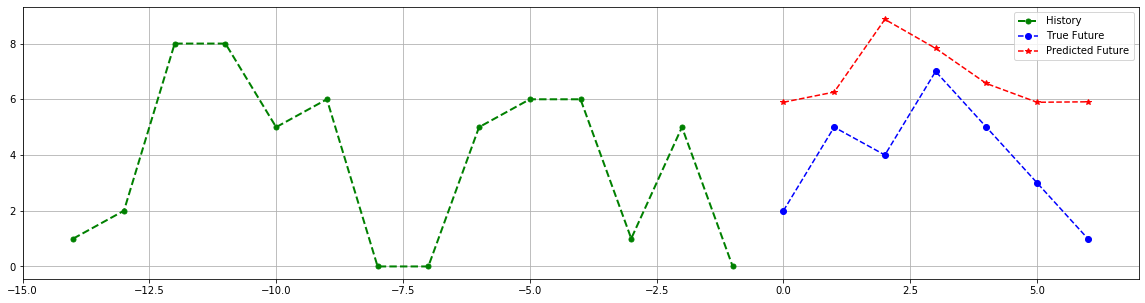

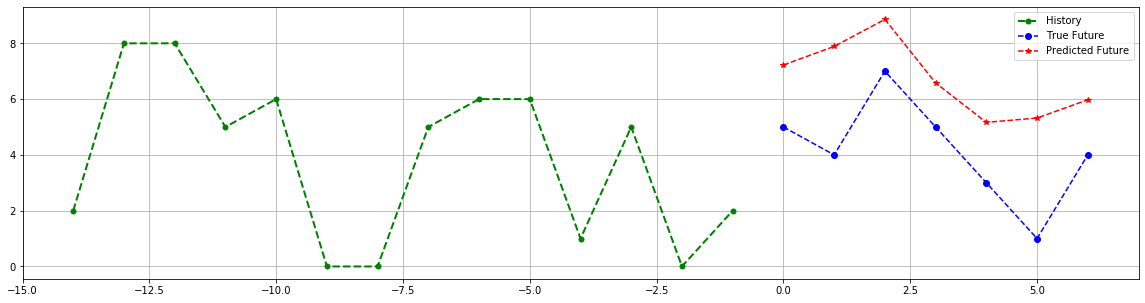

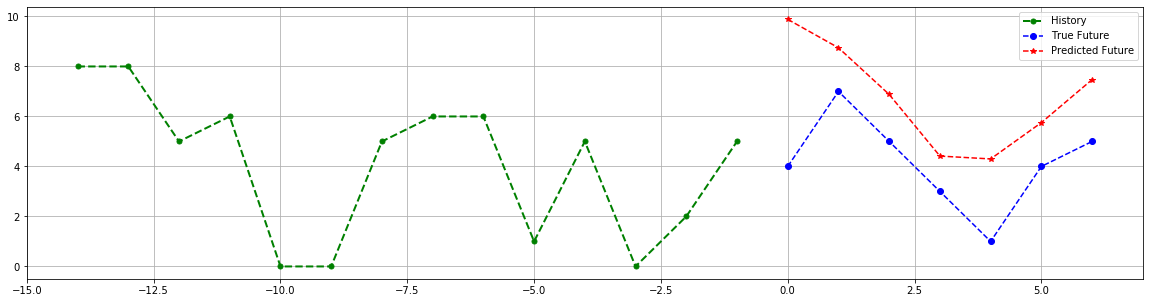

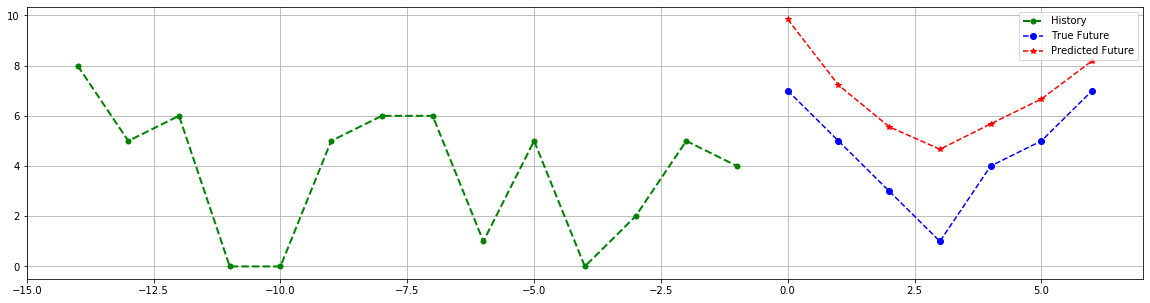

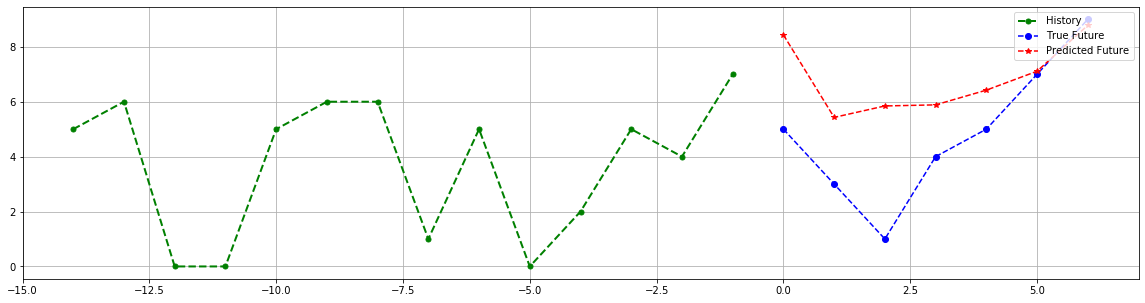

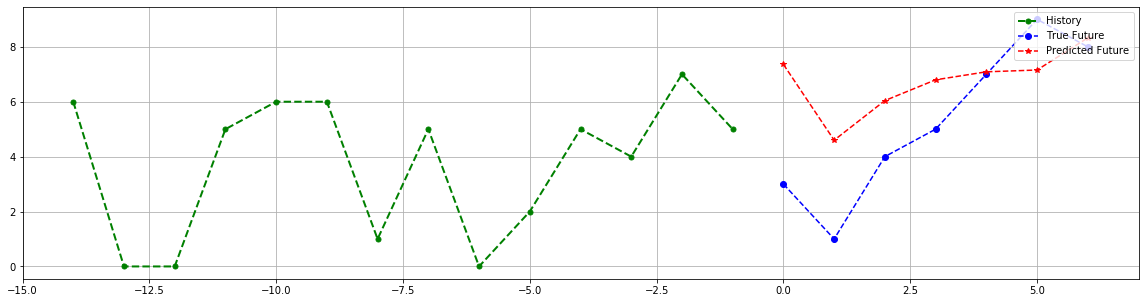

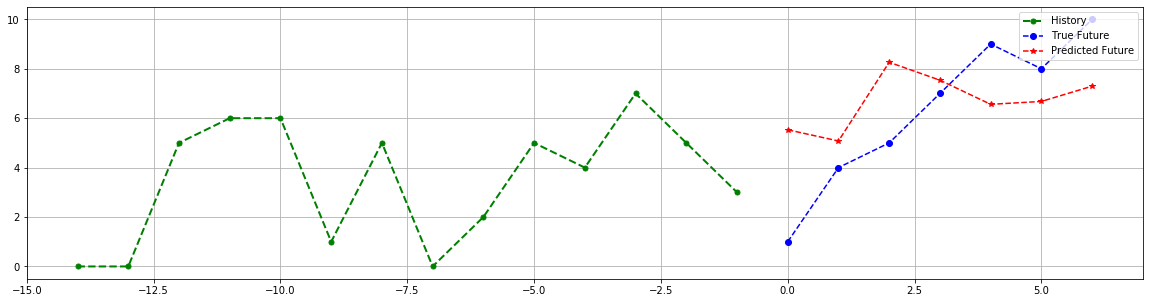

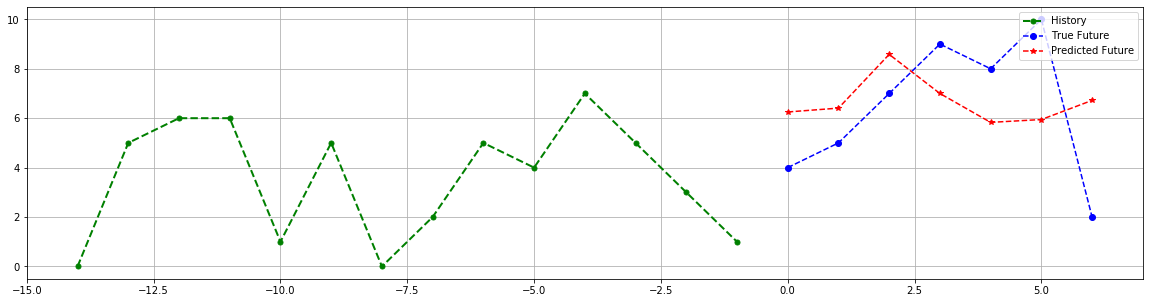

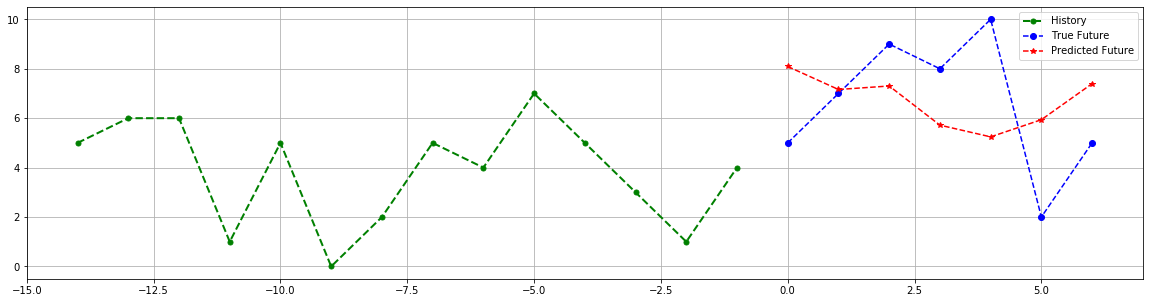

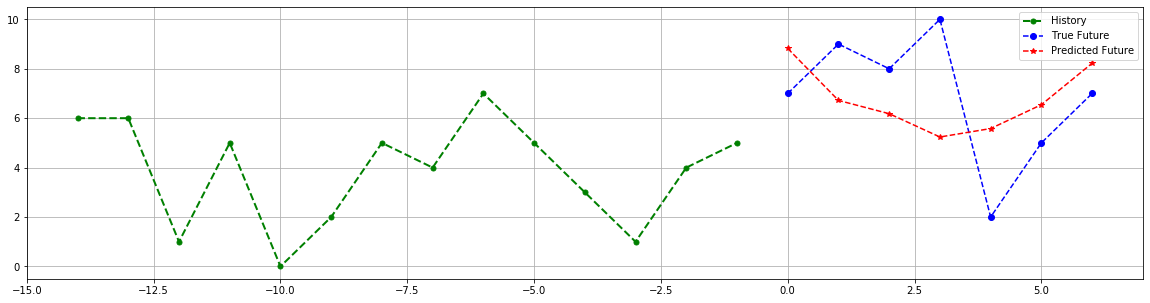

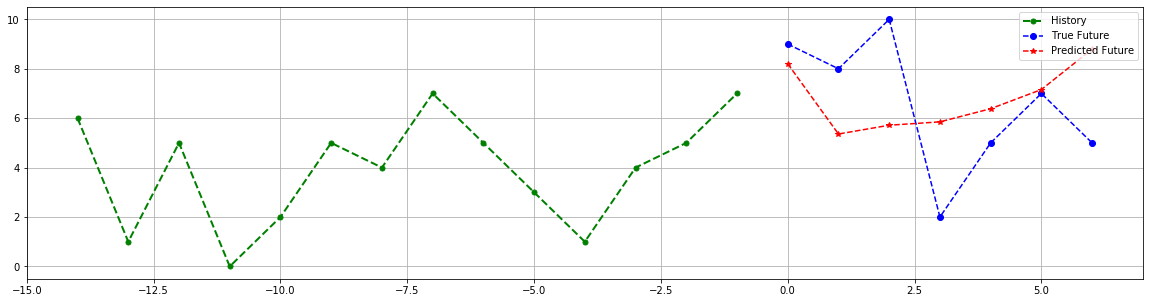

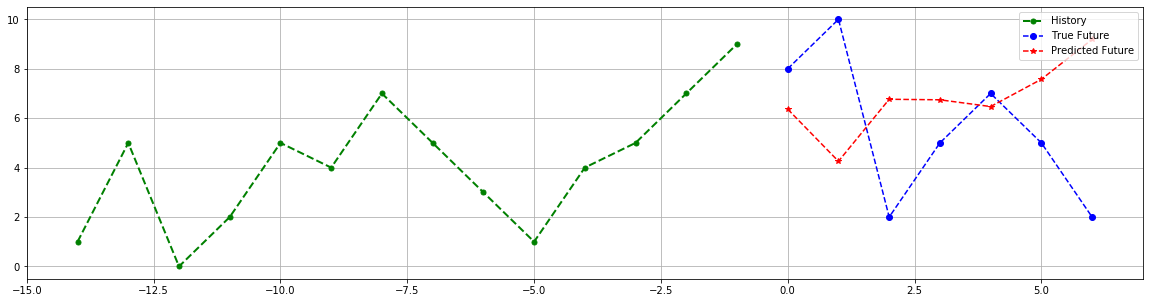

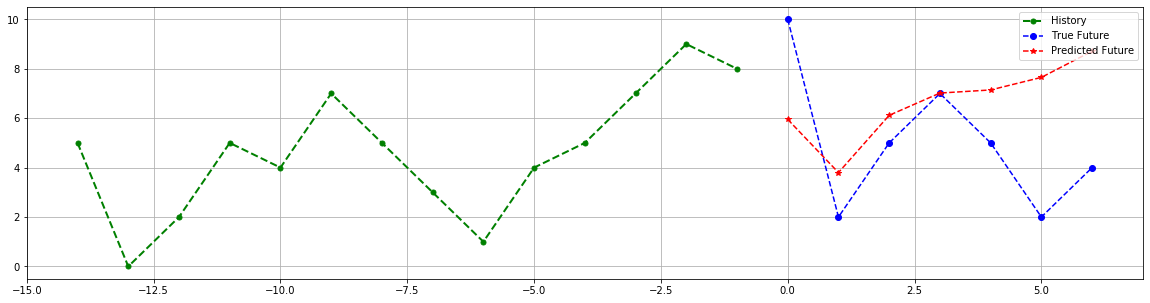

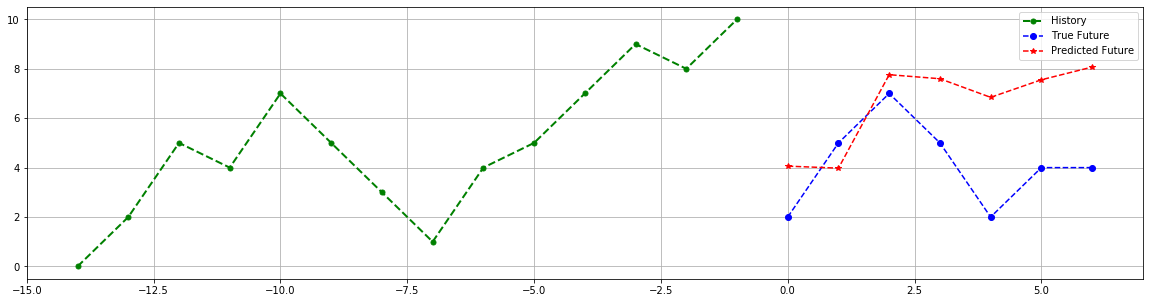

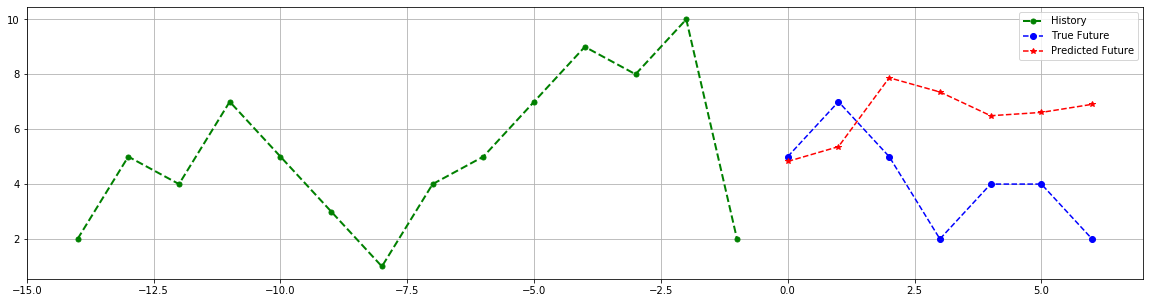

In [0]:
# Plot the true value and predicted value
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        multi_step_plot((x[i] * train_std + train_mean), (y[i] * train_std + train_mean), 
                        (multi_step_model.predict(x)[i] * train_std + train_mean))

In [0]:
score = []
for x, y in val_univariate.take(1):
    for i in range(len(x)):
        mape = evaluation((y[i] * train_std + train_mean), (multi_step_model.predict(x)[i] * train_std + train_mean))
        score.append(mape)
        print(mape)
print("MAPA is:{}".format(100 - sum(score) / len(score)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


inf
inf
inf
inf
inf
138.87946044506668
107.63346808297294
97.1712810166028
89.96272570421907
101.96908524787884
88.27727709768041
89.09180629550735
61.853249259546494
57.709226110895194
49.8722685518719
54.73657302845633
109.95269875137174
85.18571318412313
88.429264633023
103.5497844462492
MAPA is:-inf
